importing packages

In [74]:
import pandas as pd
import plotly.express as px

import geopy.distance as distance

reading provided dataset

In [75]:
metadata = pd.read_csv("metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


displaying data using plotly

In [76]:
fig = px.scatter_geo(metadata, lat='latitude',lon='longitude', hover_name="uid")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

In [77]:
test_row = metadata[metadata.uid == "aaff"].iloc[0]
test_row

uid                aaff
latitude      38.049471
longitude    -99.827001
date         2019-07-23
split             train
Name: 4, dtype: object

In [78]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(test_row.latitude, test_row.longitude, meter_buffer=50000)
bbox

[-100.39664248326538, 37.59899258863744, -99.25735973673461, 38.4999144430413]

In [79]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"

    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(test_row.date)
date_range

'2019-07-08T/2019-07-23T'

idea: loop over entries and download images for the provided lat and long

In [80]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [81]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [82]:
# bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
bbox_of_interest = bbox
date_range = get_date_range(test_row.date)

In [83]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

32

In [84]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LE07_L2SP_030034_20190712_02_T1 from 2019-07-12 with 0.0% cloud cover


In [85]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            lwir: Surface Temperature Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        cloud_qa: Cloud Quality Assessment Band
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Dropped Pixel Quality Assessment Band
   atmos_opacity: 

In [86]:
# bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
bands_of_interest = ["red", "green", "blue"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 3363, x: 3362)
Coordinates:
  * y            (y) float64 4.262e+06 4.262e+06 ... 4.161e+06 4.161e+06
  * x            (x) float64 3.767e+05 3.768e+05 ... 4.775e+05 4.776e+05
    spatial_ref  int32 32614
    time         datetime64[ns] 2019-07-12T17:08:07.584195
Data variables:
    red          (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    green        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    blue         (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

Text(0.5, 1.0, 'Natural Color, Redmond, WA')

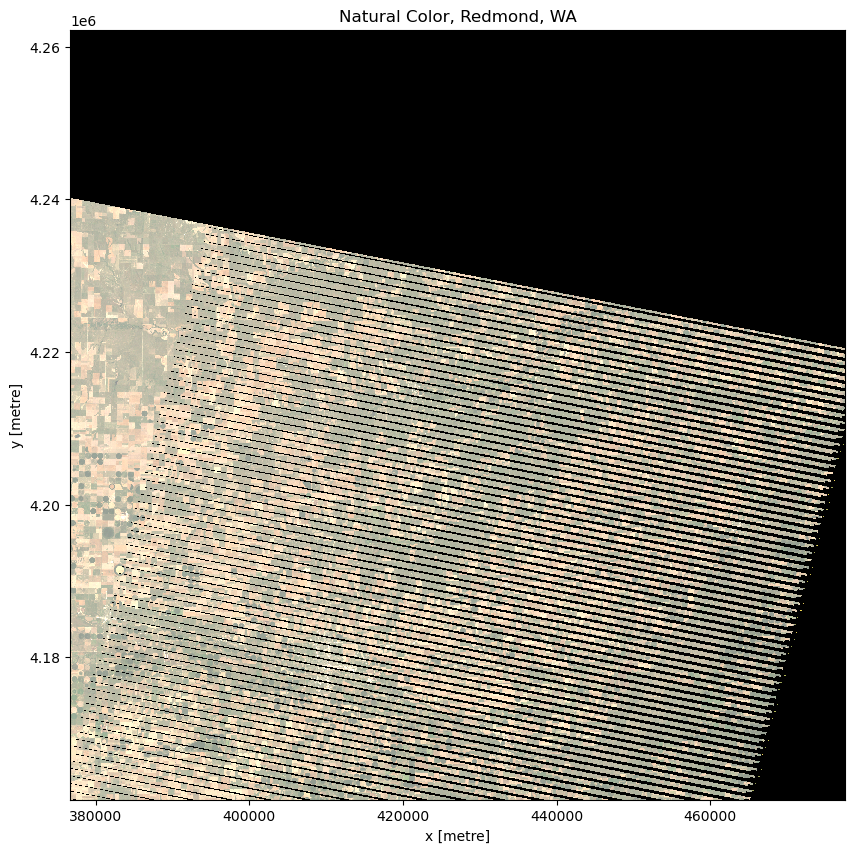

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Redmond, WA")